In [4]:
from collections import Counter
import ConfigParser
import matplotlib.pyplot as plt
import networkx as nx
import sys
import time
from TwitterAPI import TwitterAPI
from pprint import pprint
import cPickle as pickle
import ast
import os
import json
from datetime import datetime, timedelta
import ast
import re
import numpy as np
import operator
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from StringIO import StringIO
from zipfile import ZipFile
from urllib import urlopen
#from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize


%matplotlib inline

In [5]:
def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = ConfigParser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
print('Established Twitter connection.')
ht={}

def htcount():
    for i,v in ht.items():
        if v>1:
            print i,v
    print "htcountdone"
    print len(ht)

Established Twitter connection.


The htcount() function defined above is the one which checks whether the tweets collected are distinct by tweet id. This is called after the data collection.

In [6]:
def robust_request(twitter, resource, params, max_tries=5):
    """ If a Twitter request fails, sleep for 15 minutes.
    Do this at most max_tries times before quitting.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request.
      params ..... A parameter dictionary for the request.
      max_tries .. The maximum number of tries to attempt.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    for i in range(max_tries):
        request = twitter.request(resource, params)
        #print request
        if request.status_code == 200:
            return request
        else:
            print >> sys.stderr, 'Got error:', request.text, '\nsleeping for 15 minutes.'
            #print ht
            htcount()
            sys.stderr.flush()
            print datetime.utcnow()
            time.sleep(61 * 15)

In [5]:
ht={}
resource='search/tweets'
sinceid=None
params={'geocode':"41.8500,-87.650,5mi",'count':100,'max_id':sinceid}
count=0
tweet={}
stime=datetime.utcnow()
print stime
etime=datetime.utcnow() - timedelta(days=7)
print etime
done=False
fcnt=1
def get_twitter_data():
    while True:
        result=robust_request(twitter,resource,params,5)
        tweetdt=None
        #pprint(res)
        tweets=[]
        fl=open("data"+os.sep+str(fcnt), 'w+')
        for res in result:
            tweet={}
            tid=res['id']
            text=res['text']
            dat=res['created_at']
            vals=dat.split(" ")
            month=vals[1]
            dtime=vals[1]+" "+vals[2]+" "+vals[5]+" "+vals[3]
            tweetdt=datetime.strptime(dtime,"%b %d %Y %H:%M:%S")
            entity=res['entities']
            tags=[]
            urls=[]
            mentions=[]
            for tag in entity['hashtags']:
                tags.append(tag['text'])
            for url in entity['urls']:
                urls.append(url['url'])
            for ment in entity['user_mentions']:
                mentions.append(ment['screen_name'])
            tweet['id']=tid
            tweet['text']=text
            tweet['hashtags']=tags
            tweet['urls']=urls
            tweet['mentions']=mentions
            tweets.append(tweet)
            if tweetdt<etime:
                print tweetdt
                done=True
                break
            if tid in ht.keys():
                ht[tid]=ht[tid]+1
            else:
                ht[tid]=1
            count+=1
        #print count
        fl.write(str(tweets))
        fl.flush()
        fl.close()
        if done:
                break
        #sinceid=min(ht.keys(),key=int)
        sinceid=sorted(ht.keys(),key=lambda x:x)[0]
        params['max_id']=sinceid-1
        fcnt+=1
        #break
        #print sinceid


get_twitter_data()
print count
filecount=fcnt
#pprint(ht)
print len(ht)
htcount()

2015-11-30 05:40:04.812175
2015-11-23 05:40:04.812807
htcountdone

Got error: {"errors":[{"message":"Rate limit exceeded","code":88}]} 
sleeping for 15 minutes.



18000
2015-11-30 05:43:53.464424
2015-11-23 05:40:01
21421
21421
htcountdone
21421


Here the Data of one week was collected and stored in file in order to reuse. There are a total of 215 files,each containing 100 tweets. The Rest api was used to retrieve the tweet by manipulating the Tweet id and date to get a distinct set of one week tweets.

In [7]:
filecount=215 #comment this line if you have already run the above method 
#or code since the value will be dynamically

dassignedef readtweets(start,end):
    myDicts=[]
    #print start,end
    for i in range(int(start),int(end)):
        #print i
        inputFile = open("data"+os.sep+str(i), "r")
        lines = inputFile.readlines()
        objects = []
        for line in lines:
            #print line
            objects.append( (line) )
        myDict=eval(objects[0])
        myDicts+=myDict
    print "read",len(myDicts)
    return myDicts

myDicts=readtweets(1,21)
print len(myDicts)
print filecount

read 2000
2000
215


This above method readtweets() is used to read the tweets from the files in the folder data/*. It reads the no of files mentioned in start,end to get the differnce*100 tweets to memory.

In [5]:
# Dont Touch this method as this was used to manually label the first 500 tweets
# this Function was for the purpose of helping to label tweets manually and store them in "label+count" file name 
# Dont Run it also ,as it would replace the existing labels file
labels=[] 
def assign_labels_store(tweets,count): 
    label=[] 
    fl=open("labels "+str(count), 'w+') 
    for i in range(1,count+1): 
        #print label 
        value=int(raw_input(tweets[i]['text'])) 
        label.append(value) 
    fl.write(str(label)) 
    fl.flush() 
    fl.close() 
    return label 
labels=assign_labels_store(myDicts,500)

That's it now I got to sneak off to see #CREED this week!!!1
This view was taken from the 103th floor of Willus Tower. Finally I managed to be here after a super… https://t.co/tggRUZ0hWH1
I love you, Chicago ❤️ You're pretty and delicious and edgy and I'm so happy that I'm from the… https://t.co/jDz3NvsckT1
can't wait to go back to lolla with you @ Lollapalooza https://t.co/OheEEZnJ9A1
RT @am_in_america: #Chicago. Love this city ❤️🎉😍🙌🏽🍷🍷🍷🍷. View taken from a lovely little #yogi rooftop . Missing my #ytt… https://t.co/fnfb4…1
haven't gone back since 👯 call me maybe? theee_bolg @ The Hampton Social https://t.co/KAP3m02sh60
Interested in a #IT #job near #Chicago, IL? This could be a great fit: https://t.co/fTb0dZXRdZ #Hiring1
Had to come out to support my bro! zo3hree5ive @ The Promontory https://t.co/FeNZ8EUfcB1
@KBevPhoto Great to see you in line. Sorry we got separated. Enjoy the show and see you soon at Grown Folks.1
39% of the Chicago's Trends for Saturday 28 were hashtags: https://t

In [8]:
#print labels
def read_labels_from_file(filename):
    inputFile = open(filename, "r")
    lines = inputFile.readlines()
    objects = []
    for line in lines:
        #print line
        objects.append( (line) )
    mylist=eval(objects[0])
    return np.array(mylist)
mlabels=read_labels_from_file("labels 500")
print mlabels

[ 1  1  1  1  1  0  1  1  1  0 -1 -1 -1  0 -1  0  0  1  1  0  1 -1  0  0 -1
 -1  1 -1  1  0  0  1 -1  0  1  0  0  1  0  1  0  0  1 -1 -1  0  1  1  1  0
  1  0  1  1  0  1  0  1 -1  1  1  0  1  1  1  1  1  0  1 -1  0  1  0 -1 -1
  1 -1  1  1  1  1 -1  0 -1 -1  1 -1  1  0 -1  1 -1  0  1 -1  0 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  0 -1 -1  1 -1  1  0 -1 -1 -1 -1  1 -1 -1  0  1 -1 -1 -1
 -1 -1  1 -1 -1 -1 -1 -1 -1  0  0  0  0 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1
 -1  0  1  1  1  1 -1  1 -1  0 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  1 -1 -1  0 -1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  0  1 -1 -1 -1  0  0  0  1  0
  1 -1  0 -1  1 -1  1 -1 -1 -1  0  1  1 -1  0  1  1 -1 -1  0 -1 -1  1 -1  1
 -1  1  0  0 -1  1 -1  1  1 -1  0  0  1 -1  0 -1  1 -1  0 -1  0  0  0 -1  1
 -1 -1 -1  1 -1 -1  1  1 -1  0  0  1 -1  1 -1 -1  1 -1  0 -1  1 -1 -1  0 -1
 -1 -1 -1  0 -1  0 -1  1  1  1 -1 -1  1 -1  1  0 -1 -1  1  1 -1  1 -1  1 -1
 -1  0 -1  1 -1 -1  0  1 -1  1 -1 -1  1 -1 -1  1 -1  0  0  1 -1 -1  0 -1 -1
 -1 -1  0 -1

This method reads the labels which were done manually and stores them in memory.
I am using 3 classes to label the tweets

1 - positive

0 - Neutral

-1 - Negative

In [9]:
def pos_neg_neutral_count(labels):
    pos=0
    neg=0
    neu=0
    for l in labels:
        if l==1:
            pos+=1
        elif l==-1:
            neg+=1
        else:
            neu+=1
    return pos,neg,neu

print pos_neg_neutral_count(mlabels)

(175, 196, 129)


In [10]:
def tokenize(text):
    tokens=[]
    low=text.lower()
    tokens=re.findall(r'\w+', low)
    return tokens

def tokenize_with_punct(text):
    temp=re.sub(r'[\n\r\x85]',' ',text.lower())
    #tokens=re.findall(r"[\w]+|[\s]",temp.lower())
    #return tokens
    return re.findall(r"[\w]+|[^\s\w]|\x85", temp.lower())

def tokenize_with_not(text):
    tokens=tokenize_with_punct(text)
    prefix=""
    count=0
    for n,t in enumerate(tokens):
        if t=="not":
            prefix="not_"
            count=2
        elif count>0:
            tokens[n]=prefix+tokens[n]
            count-=1
        elif count==0:
            prefix=""
    return tokens

def nltk_tokenize(text):
    return word_tokenize(text.lower())

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def preprocess(text):
    tokens=tokens_re.findall(text)
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens


for tweet in myDicts:
    print tweet['text']
    print tweet['hashtags']
    print tokenize(tweet['text'])
    print tokenize_with_punct(tweet['text'])
    print tokenize_with_not(tweet['text'])
    print nltk_tokenize(tweet['text'])
    print preprocess(tweet['text'])
    break

#framingupsears @ Mary Bartelme Park https://t.co/7UpYdLfUl4
[u'framingupsears']
[u'framingupsears', u'mary', u'bartelme', u'park', u'https', u't', u'co', u'7upydlful4']
[u'#', u'framingupsears', u'@', u'mary', u'bartelme', u'park', u'https', u':', u'/', u'/', u't', u'.', u'co', u'/', u'7upydlful4']
[u'#', u'framingupsears', u'@', u'mary', u'bartelme', u'park', u'https', u':', u'/', u'/', u't', u'.', u'co', u'/', u'7upydlful4']
[u'#', u'framingupsears', u'@', u'mary', u'bartelme', u'park', u'https', u':', u'//t.co/7upydlful4']
[u'#framingupsears', u'@', u'mary', u'bartelme', u'park', u'https://t.co/7upydlful4']


In [11]:
url = urlopen('http://www2.compute.dtu.dk/~faan/data/AFINN.zip')
zipfile = ZipFile(StringIO(url.read()))
afinn_file = zipfile.open('AFINN/AFINN-111.txt')

afinn = dict()

for line in afinn_file:
    parts = line.strip().split()
    if len(parts) == 2:
        afinn[parts[0]] = int(parts[1])

print 'read', len(afinn), 'AFINN terms.\nE.g.:', afinn.items()[:10]

read 2462 AFINN terms.
E.g.: [('limited', -1), ('suicidal', -2), ('pardon', 2), ('desirable', 2), ('protest', -2), ('lurking', -1), ('controversial', -2), ('hating', -3), ('ridiculous', -3), ('hate', -3)]


In [12]:
def afinn_sentiment(terms, afinn):
    total = 0.
    for t in terms:
        if t in afinn:
            print '\t%s=%d' % (t, afinn[t])
            total += afinn[t]
    return total


In [13]:
tokens=tokenize(myDicts[5]['text'])
print myDicts[5]['text']
print 'AFINN:\n', afinn_sentiment(tokens, afinn)

RT @am_in_america: #Chicago. Love this city ❤️🎉😍🙌🏽🍷🍷🍷🍷. View taken from a lovely little #yogi rooftop . Missing my #ytt… https://t.co/fnfb4…
AFINN:
	love=3
	lovely=3
	missing=-2
4.0


In [14]:
from nltk.corpus import sentiwordnet as swn
# Depends on nltk (pip install nltk)
# See http://www.nltk.org/data.html
happy = swn.senti_synsets('happy', 'a')[0]
print happy


<happy.a.01: PosScore=0.875 NegScore=0.0>


In [15]:
happy=swn.senti_synsets('happy', 'a')[0]
type(happy)
print happy.pos_score()

0.875


In [16]:
def senti_score(terms):
    pos = 0
    neg = 0
    for t in terms:
        term=swn.senti_synsets(t)
        #print term,t
        if len(term):
            pos+=term[0].pos_score()
            neg+=term[0].neg_score()
        #print pos,neg,t
    return pos, neg

print myDicts[5]['text']
print senti_score(tokens),tokens

RT @am_in_america: #Chicago. Love this city ❤️🎉😍🙌🏽🍷🍷🍷🍷. View taken from a lovely little #yogi rooftop . Missing my #ytt… https://t.co/fnfb4…
(0.875, 0.5) [u'rt', u'am_in_america', u'chicago', u'love', u'this', u'city', u'view', u'taken', u'from', u'a', u'lovely', u'little', u'yogi', u'rooftop', u'missing', u'my', u'ytt', u'https', u't', u'co', u'fnfb4']


In [17]:
def sentiword_classifier(tweets,tokenizer_fn=tokenize):
    y=[]
    for t in tweets:
        tokens=tokenizer_fn(t['text'])
        pos,neg=senti_score(tokens)
        if (pos>neg):
            y.append(1)
        elif pos<neg:
            y.append(-1)
        else :
            y.append(0)
    return np.array(y)

senti_labels=sentiword_classifier(myDicts[:500])
#print y
print "No of Tweets",len(senti_labels)
print pos_neg_neutral_count(senti_labels)

No of Tweets 500
(185, 125, 190)


This method uses the SentiWordNet to classify the tweets and assign labels to them

In [18]:
# comparison between the manually labelled tweets and the sentiwordnet labelled tweets(500 tweets)
acc = accuracy_score(mlabels,senti_labels)
print "The senti_labels had an accuracy of",acc,"when compared to the manually labelled tweets"

The senti_labels had an accuracy of 0.356 when compared to the manually labelled tweets


In [19]:
print "Format of tweet stored in file and retrieved",myDicts[5]

Format of tweet stored in file and retrieved {'text': u'RT @am_in_america: #Chicago. Love this city \u2764\ufe0f\U0001f389\U0001f60d\U0001f64c\U0001f3fd\U0001f377\U0001f377\U0001f377\U0001f377. View taken from a lovely little #yogi rooftop . Missing my #ytt\u2026 https://t.co/fnfb4\u2026', 'hashtags': [u'Chicago', u'yogi', u'ytt'], 'id': 671200182604718080L, 'urls': [u'https://t.co/fnfb4sdsnG'], 'mentions': [u'am_in_america']}


In [20]:
# do the vectorize on the 500 tweets which we manually classified

def do_vectorize(tweets, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    
    cvt=CountVectorizer(input='string',tokenizer=tokenizer_fn, ngram_range=ngram_range, max_df=max_df, 
                        min_df=min_df, binary=binary,dtype=int)
    '''CountVectorizer(input='content', encoding='utf-8', decode_error='strict', 
                    strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, 
                    token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, 
                    max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)'''
    vec=cvt.fit_transform(t['text'] for t in tweets)
    return (vec,cvt)
    
matrix, vec = do_vectorize(myDicts[:500])
#print matrix
print 'vectorized %d tweets. found %d terms.' % (matrix.shape[0], matrix.shape[1])

vectorized 500 tweets. found 1857 terms.


In [21]:
def get_clf():
    return LogisticRegression(random_state=42)

def do_cross_validation(X, y, n_folds=5, verbose=False):
    cv = KFold(len(y), n_folds)
    accuracies = []
    index=0
    for train_idx, test_idx in cv:
        #print train_idx, test_idx
        clf = get_clf()
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        accuracies.append(acc)
        if verbose==True:
            print "fold",index,"accuracy=%.4f"%acc
        index+=1
    avg = np.mean(accuracies)
    return avg
    
print('average cross validation accuracy=%.4f' % do_cross_validation(matrix , mlabels , verbose=True))

fold 0 accuracy=0.2800
fold 1 accuracy=0.4000
fold 2 accuracy=0.2800
fold 3 accuracy=0.3800
fold 4 accuracy=0.3000
average cross validation accuracy=0.3280


My manually labelled data gave a poor average accuracy of 32%. This is due to the nature of the tweets 
and the inability of the classfier to understand sarcasm and pseudonyms of the English language which is difficult to quantify. Also this brings in the concept of human error also, as I am the one labelling the tweets and assigning values and the labels will be morally biased towards my view of tweets (Example a tweet which i will give a negative label, can be given a neutral or even positive label by another person). In order to get a more globalised view we would need to build a much much more complex Classifier or machine learning algorithm. This leads us to use some other way of labelling the tokens such as the SentiWordNet method.

In [22]:
print('average cross validation accuracy=%.4f' % do_cross_validation(matrix, senti_labels, verbose=True))

fold 0 accuracy=0.6500
fold 1 accuracy=0.7800
fold 2 accuracy=0.8500
fold 3 accuracy=0.7400
fold 4 accuracy=0.6200
average cross validation accuracy=0.7280


On the other hand the sentiword which gives labels based on preassigned positive and negative token values does better with an average accuracy of 72%. This gives us a better way to labelling the tweets. It also has the advantage of a globally symantic view due to its predefined nature. The clash of the different human views is also avoided. Also I can use the function to label and train on more data rather than just 500 tweets and this will increase the accuracy even more.

In [23]:
model = LogisticRegression()
model.fit(matrix,np.array(mlabels))

def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model.predict(matrix)
print "This gives the accuracy of classifier by training and testing on same set. This is using Manual labels"
print 'accuracy on training data=%.3f' % accuracy(np.array(mlabels), predicted)

This gives the accuracy of classifier by training and testing on same set. This is using Manual labels
accuracy on training data=0.884


In [24]:
model = LogisticRegression()
model.fit(matrix,senti_labels)

def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model.predict(matrix)
print "This gives the accuracy of classifier by training and testing on same set. This is using SentiWordNet labels"
print 'accuracy on training data=%.3f' % accuracy(senti_labels, predicted)

This gives the accuracy of classifier by training and testing on same set. This is using SentiWordNet labels
accuracy on training data=0.996


In [25]:
cv = KFold(len(mlabels), 5)
accuracies = []
for train_ind, test_ind in cv:
    #print 1
    #print train_ind,test_ind
    #print type(train_ind)
    #print train_ind[0]
    #print train_ind
    model.fit(matrix[train_ind], mlabels[train_ind])
    predictions = model.predict(matrix[test_ind])
    accuracies.append(accuracy(mlabels[test_ind], predictions))
print accuracies
print 'Average 5-fold cross validation accuracy=%.2f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies))

[0.28, 0.4, 0.28, 0.38, 0.3]
Average 5-fold cross validation accuracy=0.33 (std=0.05)


In [26]:
def do_expt(filenames, y, tokenizer_fn=tokenize,
            min_df=1, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=5):
    matrix, vec = do_vectorize(filenames,tokenizer_fn=tokenizer_fn,min_df=min_df, max_df=max_df,
                               binary=binary,ngram_range=ngram_range)
    #X, y, filenames = repeatable_shuffle(matrix, y, all_train_files)
    #print do_cross_validation(X, y,n_folds=n_folds)
    return do_cross_validation(matrix, y,n_folds=n_folds)

print('accuracy using default settings and manual labels: %.4g' % do_expt(myDicts[:500], np.array(mlabels)))
print('accuracy using default settings and senti lables: %.4g' % do_expt(myDicts[:500], senti_labels))

accuracy using default settings and manual labels: 0.328
accuracy using default settings and senti lables: 0.728


manual labels:


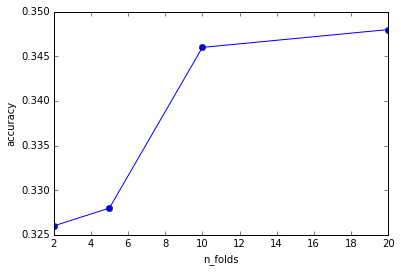

[0.32600000000000001, 0.32800000000000001, 0.34599999999999997, 0.34799999999999998]
senti labels:


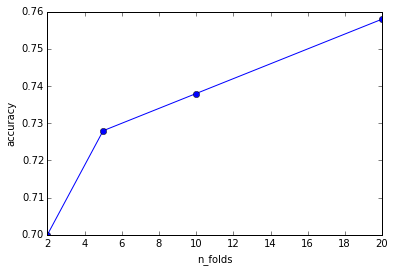

[0.69999999999999996, 0.72799999999999998, 0.73799999999999999, 0.75800000000000001]


In [27]:
def compare_n_folds(filenames, y):
    """
    Vary the setting of n_folds parameter in the do_expt 
    function to be in [2,5,10,20]. For each setting, call do_expt and 
    store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per fold.
    """
    ###TODO
    ###
    n_folds=[2,5,10,20]
    accuracies = []
    for nf in n_folds:
        accuracies.append(do_expt(filenames, y,n_folds=nf))
    plt.figure()
    plt.plot(n_folds,accuracies, 'bo-')
    plt.xlabel('n_folds')
    plt.ylabel('accuracy')
    plt.show()
    return accuracies
print "manual labels:"
print compare_n_folds(myDicts[:500], mlabels)
print "senti labels:"
print compare_n_folds(myDicts[:500], senti_labels)

In [28]:
def compare_binary(filenames, y):
    """
    How does the binary parameter affect results? 
    Call do_expt twice, once with binary=True, and once with binary=False.
    Return the average accuracies for each. Use the default parameters for the
    remaining arguments in do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies. The first entry
        is for binary=True, the second is for binary=False.
    """
    ###TODO
    ###
    return [do_expt(filenames,y,binary=b) for b in [True, False]]
print "manual labels:"
print compare_binary(myDicts[:500], mlabels)
print "senti labels:"
print compare_binary(myDicts[:500], senti_labels)

manual labels:
[0.32800000000000001, 0.308]
senti labels:
[0.72799999999999998, 0.72199999999999998]


In [29]:
def tokenizer_expt(all_train_files, y):
    """
    How does the tokenizer affect results? 
    Call do_expt three times, using three different tokenizers:
    1- tokenize
    2- tokenize_with_punct
    3- tokenize_with_not
    Return the average cross-validation accuracy for each approach,
    in the above order. Use the default parameters for all other 
    arguments to do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies for each tokenizer.
    """
    ###TODO
    ###
    l=[]
    l.append(do_expt(all_train_files,y,tokenizer_fn=tokenize))
    l.append(do_expt(all_train_files,y,tokenizer_fn=tokenize_with_punct))
    l.append(do_expt(all_train_files,y,tokenizer_fn=tokenize_with_not))
    l.append(do_expt(all_train_files,y,tokenizer_fn=nltk_tokenize))
    l.append(do_expt(all_train_files,y,tokenizer_fn=preprocess))
    return l
print "manual labels:"
print tokenizer_expt(myDicts[:500], mlabels)
print "senti labels:"
print tokenizer_expt(myDicts[:500], senti_labels)

manual labels:
[0.32800000000000001, 0.32800000000000001, 0.32800000000000001, 0.31, 0.33000000000000002]
senti labels:
[0.72799999999999998, 0.70999999999999996, 0.71199999999999997, 0.70999999999999996, 0.72799999999999998]


manual labels:


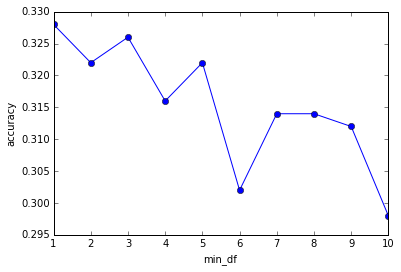

[0.32800000000000001, 0.32199999999999995, 0.32599999999999996, 0.316, 0.32200000000000001, 0.30199999999999999, 0.314, 0.314, 0.312, 0.29799999999999999]
senti labels:


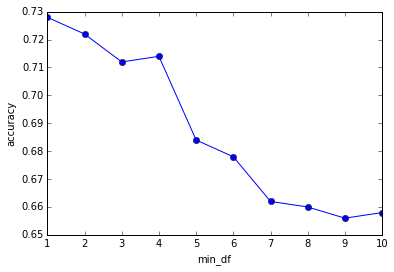

[0.72799999999999998, 0.72199999999999998, 0.71199999999999997, 0.71399999999999997, 0.68399999999999994, 0.67799999999999994, 0.66200000000000003, 0.65999999999999992, 0.65600000000000003, 0.65800000000000003]


In [30]:
def min_df_expt(filenames, y):
    """
    Vary the setting of min_df parameter in the do_expt 
    function to be ints in the range (1,10) (inclusive). For each setting,
    call do_expt and store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function, except that the toke,nizer
    should be tokenize_with_not.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per min_df value.
    """
    ###TODO
    ###
    accuracies = []
    for i in range(1,11):
        accuracies.append(do_expt(filenames, y,tokenizer_fn=tokenize,min_df=i))
    plt.figure()
    plt.plot(range(1,11),accuracies, 'bo-')
    plt.xlabel('min_df')
    plt.ylabel('accuracy')
    plt.show()
    return accuracies
print "manual labels:"
print min_df_expt(myDicts[:500], mlabels)
print "senti labels:"
print min_df_expt(myDicts[:500], senti_labels)

manual labels:


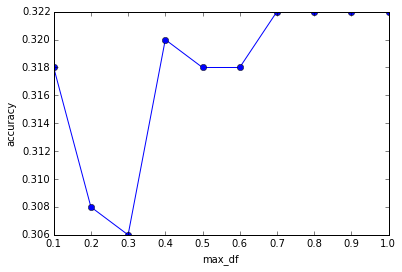

[0.318, 0.308, 0.30599999999999999, 0.32000000000000001, 0.31799999999999995, 0.31799999999999995, 0.32199999999999995, 0.32199999999999995, 0.32199999999999995, 0.32199999999999995]
senti labels:


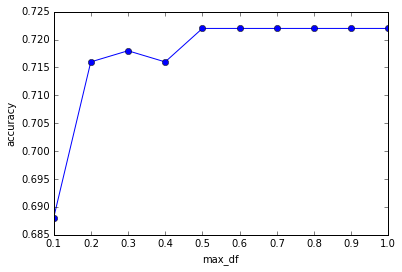

[0.68799999999999994, 0.71599999999999997, 0.71799999999999997, 0.71599999999999997, 0.72199999999999998, 0.72199999999999998, 0.72199999999999998, 0.72199999999999998, 0.72199999999999998, 0.72199999999999998]


In [31]:
def max_df_expt(filenames, y):
    """
    Vary the setting of max_df parameter in the do_expt 
    function to be one of [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.].
    For each setting, call do_expt and store the resulting accuracy.
    Plot the accuracies for each setting. Also return the list of accuracies.
    Use the default value for all other arguments to the do_expt function,
    except that the tokenizer=tokenize_with_not and min_df=2.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per max_df value.
    """
    ###TODO
    ###
    maxs=[.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
    accuracies = []
    for i in maxs:
        accuracies.append(do_expt(filenames, y,tokenizer_fn=tokenize,max_df=i,min_df=2))
    plt.figure()
    plt.plot(maxs,accuracies, 'bo-')
    plt.xlabel('max_df')
    plt.ylabel('accuracy')
    plt.show()
    return accuracies
print "manual labels:"
print max_df_expt(myDicts[:500], mlabels)
print "senti labels:"
print max_df_expt(myDicts[:500], senti_labels)

As of the above experiments we can conclude that the optimal setting for the vectorizer function are
1) n_fold = 5 or above
2) binary = True
3) tokenizer function = tokenize
4) min_dt = 2
5) max_dt = 0.5

Preprocess also does pretty well but when training on large amount of data,there was a drop in accuracy. I havent included the data. But that is why i decided to use tokenize function itself.

As discussed above we will be using the sentiwordnet to classify the 22k tweets.

In [32]:
#READ ALL THE TWEETS WHICH IS FOR ONE WEEK
dataset=readtweets(1,filecount+1)
data_y=sentiword_classifier(dataset)
print len(dataset),"tweets were read"

read 21422
21422 tweets were read


In [33]:
print('accuracy using optimal settings: %.4g with 5 folds' % do_expt(dataset, data_y,tokenizer_fn=tokenize,
                                                        min_df=2, max_df=0.5, binary=True,
                                                        ngram_range=(1,1), n_folds=5))
print('accuracy using optimal settings: %.4g with 2 folds' % do_expt(dataset, data_y,tokenizer_fn=tokenize,
                                                        min_df=2, max_df=0.5, binary=True,
                                                        ngram_range=(1,1), n_folds=2))

accuracy using optimal settings: 0.8599 with 5 folds
accuracy using optimal settings: 0.8335 with 2 folds


In [34]:
datamatrix, vec = do_vectorize(dataset,tokenizer_fn=tokenize,min_df=2, max_df=0.5,
                               binary=True)
print 'vectorized %d tweets. found %d terms.' % (datamatrix.shape[0], datamatrix.shape[1])
voc=np.array(vec.get_feature_names())
def document_frequencies(movie_term_matrix):
    
    df = np.zeros(len(voc))
    #print np.array_str(df)
    rows,cols = movie_term_matrix.nonzero()
    for row,col in zip(rows,cols):
        #print ((row,col), movie_term_matrix[row,col])
        df[col]+=1
    return [zip(range(0,len(df)),df)]
countlist=document_frequencies(datamatrix)
#print sorted(countlist, key=lambda t: t[1],reverse=TRUE)[:10]

vectorized 21422 tweets. found 11442 terms.


In [35]:
#print countlist
toptrends=sorted(countlist[0], key=lambda t: t[1],reverse=True)[:10]
print toptrends

[(2172, 10220.0), (5181, 5147.0), (5229, 4990.0), (10111, 4979.0), (5565, 3846.0), (10323, 3334.0), (4899, 3313.0), (1073, 3250.0), (549, 3115.0), (4118, 2923.0)]


In [36]:
for t in toptrends:
    print "The Term",voc[t[0]],"has count",t[1]

The Term chicago has count 10220.0
The Term il has count 5147.0
The Term in has count 4990.0
The Term the has count 4979.0
The Term job has count 3846.0
The Term to has count 3334.0
The Term hiring has count 3313.0
The Term at has count 3250.0
The Term a has count 3115.0
The Term for has count 2923.0


As can be seen from above,

When i uses tokens from the tweet to determing the top trends in the 22k tweets it is giving out a lot of noise. And segregating through those will take manual work. Hence lets look at using the hashtags which we collected to determine the top trends.

In [38]:
htags={}
for ds in dataset:
    hts=ds['hashtags']
    for ht in hts:
        if ht.lower() in htags.keys():
            htags[ht.lower()]+=1
        else:
            htags[ht.lower()]=1
#print htags
sorted_hts = sorted(htags.items(), key=operator.itemgetter(1),reverse=True)
print sorted_hts[:20]

[(u'chicago', 5032), (u'job', 3822), (u'hiring', 3331), (u'careerarc', 1747), (u'jobs', 1696), (u'ncaa', 531), (u'hospitality', 512), (u'ncaaw', 472), (u'veterans', 431), (u'it', 344), (u'sales', 340), (u'accounting', 267), (u'businessmgmt', 247), (u'retail', 234), (u'trndnl', 221), (u'thanksgiving', 205), (u'healthcare', 171), (u'laquanmcdonald', 164), (u'finance', 161), (u'nursing', 147)]


As can be seen above 

We have used hashtags of the tweets to determine the top trends. Here the data is much more clear and no noise. But still there are some like "job" and "Job". We removed those by using lower func.But it still doesnt eliminate tags like "jobs".

In [39]:
#htags={}
def gettophashtags(data,top):
    for ds in dataset:
        hts=ds['hashtags']
        for ht in hts:
            if ht.lower() in htags.keys():
                htags[ht.lower()]+=1
            else:
                htags[ht.lower()]=1
    sorted_hts = sorted(htags.items(), key=operator.itemgetter(1),reverse=True)
    return sorted_hts[:top]
#tophashtags=gettophashtags(dataset,10)

In [40]:
# The indicies of the tweets containing the tag which has been inputed.
#In this case we are using it to get the indicies of top hashtags.
def indicies_top_htags(dataset,topht):
    i=0
    topdata=[]
    for ds in dataset:
        hts=ds['hashtags']
        #print hts
        for ht in hts:
            #print hts
            if topht==ht.lower():
                if i not in topdata:
                    topdata.append(i)
        i+=1
    return topdata

indtop=indicies_top_htags(dataset,sorted_hts[0][0])
print len(indtop)
#print indtop

5028


In [41]:
dataset[34]
def index_of_term(vec, term):
    """ This returns the column index corresponding to this term."""
    return vec.get_feature_names().index(term)



In [42]:
print len(data_y)
a=np.append([indtop[0]],indtop[1:])
clf = get_clf()
#clf.fit(matrix, data_y)

train_matrix, vec = do_vectorize(dataset,tokenizer_fn=tokenize,min_df=2, max_df=0.5,binary=True)
print 'vectorized %d tweets. found %d terms.' % (train_matrix.shape[0], train_matrix.shape[1])
#train_y=sentiword_classifier(dataset)
clf.fit(train_matrix, data_y)

predicted = clf.predict(train_matrix[a])
acc = accuracy_score(data_y[a], predicted)
print "amount of pos-neg-neutral lables is",pos_neg_neutral_count(predicted)
print acc

21422
vectorized 21422 tweets. found 11442 terms.
amount of pos-neg-neutral lables is (1699, 1450, 1879)
0.9592283214


Here we train on the entire 22 k tweets with senti_lables and then predict on the tweets containing the hashtag "chicago" and this gives us an accuracy of 95% which is good. Also the no of positive label is more than negative. Hence clearly there is a positive sentiment towards the Hash Tag "chicago" of the 5k tweets found.

In [44]:
def do_expt_topHashtags(X,y,tophts,n,verbose=True):
    accuracies=[]
    index=0
    for top in tophts[:n]:
        indtop=indicies_top_htags(dataset,top[0])
        #print top[0]
        #print len(indtop)
        a=np.append([indtop[0]],indtop[1:])
        drange=range(len(dataset))
        for x in indtop:
            drange.remove(x)
        #print drange
        #print len(a)
        b=np.append(drange[0],drange[1:])
        clf = get_clf()
        clf.fit(X[b], y[b])
        predicted = clf.predict(X[a])
        acc = accuracy_score(y[a], predicted)
        accuracies.append(acc)
        if verbose==True:
            print "top element",top[0],"with count",len(indtop),"has accuracy=%.4f"%acc
            print "amount of pos-neg-neutral lables is",pos_neg_neutral_count(predicted)
        index+=1
    avg = np.mean(accuracies)
    #print accuracies
    return avg
do_expt_topHashtags(train_matrix,data_y,sorted_hts,20)

top element chicago with count 5028 has accuracy=0.7365
amount of pos-neg-neutral lables is (1738, 1186, 2104)
top element job with count 3822 has accuracy=0.6688
amount of pos-neg-neutral lables is (995, 877, 1950)
top element hiring with count 3330 has accuracy=0.8423
amount of pos-neg-neutral lables is (1025, 1044, 1261)
top element careerarc with count 1747 has accuracy=0.9376
amount of pos-neg-neutral lables is (571, 608, 568)
top element jobs with count 1696 has accuracy=0.8267
amount of pos-neg-neutral lables is (558, 305, 833)
top element ncaa with count 531 has accuracy=0.9699
amount of pos-neg-neutral lables is (23, 11, 497)
top element hospitality with count 512 has accuracy=0.2305
amount of pos-neg-neutral lables is (63, 170, 279)
top element ncaaw with count 472 has accuracy=0.9470
amount of pos-neg-neutral lables is (39, 21, 412)
top element veterans with count 431 has accuracy=0.8747
amount of pos-neg-neutral lables is (275, 99, 57)
top element it with count 344 has accu

0.82190589520515489

Here we do an experiment on the top 20 trends based on hashtags. Here we train on the whole dataset without the tweets containing the top hashtag. Then we test on the dataset containing only the tweets having that hashtag.
Thus we are able to predict the nature of trends which are new to twitter based on other data. This also gives us an average accuracy of 82%.